Lexical semantic recognition

In [ ]:
!pip install anvil-uplink
!python -m spacy download en_core_web_md
!pip3 install python-docx

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


     |████████████████████████████████| 96.4 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
import pandas as pd
import csv
import spacy
import re
import json
import en_core_web_md
gobal_nlp = en_core_web_md.load()

class IE:

  def __init__(self, lines):
    #-------------------------------------
    # Read ultrasound term dictionary
    #------------------------------------ 
    self.nlp = gobal_nlp
    rad_csv = pd.read_csv('radiology_dictionary.csv',names=['entity','category']) 
    self.rad_dict = dict(zip(rad_csv.entity, rad_csv.category))
    self.dict_list = rad_csv['entity'].tolist()

    #-------------------------------------
    # Read supersense dictionary
    #------------------------------------ 

    self.supersense_dictionary = {}
    with open('SS_dictionary.json') as json_file:
        self.supersense_dictionary = json.load(json_file)

    #-------------------------------------
    # Read supersence-relations mapping
    #------------------------------------ 

    rel_ss_df = pd.read_csv("SS_rel_mapping.csv", names=['SS','rel'])
    self.dict_from_csv = dict(zip(rel_ss_df.SS, rel_ss_df.rel))


    self.lines = lines
    self.dynamic_KG_triplets = None


  def get_dynamic_KG_triplets(self):
    df = pd.read_csv('TripletsKG.csv')
    return df

  #--------------------------------------------------------------
  #  find max substring
  #--------------------------------------------------------------       
  def substringSieve(self,string_list):
    out = []
    for s in string_list:
      if not any([s in entity for entity in string_list if s != entity]):
        out.append(s)
    return out

  def get_pos(self, word, tokens, pos_list):
    print(word, tokens, pos_list)
    words = word.split(' ')
    if len(words) > 1:
      word = words[-1]
    try :
      index = tokens.index(word)
    except ValueError :
      index  = 0    
    return pos_list[index]

  def get_property_relation(self, ent_1,ent_2, single_entity):
    ###print('get_property_relation', ent_1, ent_2)
    seq = 1
    adp = ''
    rel = 'PropertyOf'
    try:
      cat1 = self.rad_dict[ent_1]
    except KeyError as e:
      cat1 = 'property'
    try:
      cat2 = self.rad_dict[ent_2]
    except KeyError as e:
      cat2 = 'property'

    if cat1 == 'anatomy' and cat2 == 'anatomy':
      rel = 'PartOf'
      #depend on adp : todo
      if single_entity:
        seq = 2
      else:
        seq = 1
      ##print(ent_1, cat1, ent_2, cat2)
    elif cat1 == 'anatomy' and cat2 == 'property':
      rel = 'PropertyOf'
      seq = 2
    elif cat1 == 'anatomy' and cat2 == 'finding':
      rel = 'FoundIn'
      seq = 2
    elif cat1 == 'finding' and cat2 == 'anatomy':
      rel = 'FoundIn'
      seq = 1 
    elif cat1 == 'anatomy' and cat2 == 'observation':
      rel = 'FoundIn'
      seq = 2
    elif cat1 == 'observation' and cat2 == 'anatomy':
      rel = 'FoundIn'
      seq = 1         
    elif cat1 == 'property' and cat2 == 'finding':
      rel = 'PropertyOf'
      seq = 1
    elif cat1 == 'property' and cat2 == 'anatomy':
      rel = 'PropertyOf'
      seq = 1
    elif cat2 == 'property' and cat1 == 'finding':
      rel = 'FoundIn'
      seq = 1
    elif cat2 == 'property' and cat1 == 'anatomy':
      rel = 'PropertyOf'
      seq = 2
    elif cat1 == 'anatomy_modifier' and cat2 == 'anatomy':
      rel = 'ModifierOf'
      adp = ' to'
      seq = 1
    elif cat2 == 'anatomy_modifier' and cat1 == 'anatomy':
      rel = 'ModifierOf'
      adp = ' to'
      seq = 2
    elif cat2 == 'modifier' and cat1 == 'finding':
      rel = 'ModifierOf'
      seq = 2
    elif cat1 == 'modifier' and cat2 == 'finding':
      rel = 'ModifierOf'
      seq = 1

    return cat1, cat2, rel, seq, adp

  def process_noun_chunk(self, ent_1, token_SS_dict, writer, triplet_writer, entity_writer):
    ##print('process noun chunk',ent_1)
    token1 = token_SS_dict[ent_1]
    token_list = token1['token_list']
    root_list = token1['root_list']
    pos_list = token1['pos_list']
    root_element_lst = []
    #get root of element
    ##print('root list', token1, root_list)
    substr_lst = [' and ',' or ',' & ']
    if any([substring in ent_1.text for substring in substr_lst]):
      ##print('in if')
      entlst = re.split(' and | or | & ',ent_1.text.strip())
      for entity in entlst:
        dictinary_match_list  = [s for s in self.dict_list if (" " + s.strip() + " ") in " " + entity.strip() + " "]
        dictinary_match_list = self.substringSieve(dictinary_match_list)  
        
        ##print(dictinary_match_list)
        root_element_lst.append(dictinary_match_list[0])
   
    else:
      ##print('in else')
      dictinary_match_list  = [s for s in self.dict_list if (" " + s.strip() + " ") in " " + ent_1.text.strip() + " "]
      ##print('dictionary matched',dictinary_match_list)
      dictinary_match_list = self.substringSieve(dictinary_match_list)  
      #print('dictionary matched',dictinary_match_list)
      unmatched_entities = []
      if (len(dictinary_match_list)!=0):
        matched_sent = ' '.join(dictinary_match_list)
        unmatched_entities = set(token_list).difference(set(matched_sent.split()))

      else:
        unmatched_entities = token_list


      ###print('unmatched',unmatched_entities)
      if (len(dictinary_match_list)!=0):
        root_element_list = [s for s in dictinary_match_list if str(root_list) in s]
        if (len(root_element_list) != 0):
          root_element = root_element_list[0]
        else:
          root_element = str(root_list)        
      else:
        root_element = str(root_list)

      ###print(dictinary_match_list)
      for s in dictinary_match_list:
        try:
          cat = self.rad_dict[s]
        except KeyError as e:
          cat = 'unknown'
        entity_writer.writerow({'ent': s , 'cat': cat })
        

        if s != root_element:
          s_pos = self.get_pos(s,token_list, pos_list )

          if s_pos in (['PROPN','NOUN','ADJ','VERB']):

            cat1, cat2, rel, seq, adp = self.get_property_relation(s, root_element, True)
            #print(s, root_element, cat1, cat2)
            if seq == 1:
              writer.writerow({'ent1': s + adp , 'cat1': cat1, 'rel' : 'ModifierOf' ,'ent2': root_element, 'cat2' : cat2 })
              triplet_writer.writerow({'ent1': s + adp , 'cat1': cat1, 'rel' : 'ModifierOf' ,'ent2': root_element, 'cat2' : cat2 })
            else:
              writer.writerow({'ent1': root_element + adp, 'cat1' : cat2, 'rel' : rel ,'ent2': s, 'cat2': cat1 })
              triplet_writer.writerow({'ent1': root_element + adp , 'cat1' : cat2, 'rel' : rel ,'ent2': s, 'cat2': cat1 })
      
      for word in unmatched_entities:
        s_pos = self.get_pos(word,token_list, pos_list)      
        if s_pos in (['PROPN','NOUN','ADJ','VERB','NUM']):
          entity_writer.writerow({'ent': word , 'cat': 'property' })
          if word != root_element:

            writer.writerow({'ent1': word , 'rel' : 'ModifierOf' ,'ent2': root_element })
            triplet_writer.writerow({'ent1': word , 'rel' : 'ModifierOf' ,'ent2': root_element })

      root_element_lst.append(root_element)
      
    return root_element_lst

  def get_relation(self, ent_1, verb, ent_2, token_SS_dict, writer, triplet_writer, entity_writer):
    ###print('get relation', ent_1, ent_2)

    #TODO: if noun chunk contains conjugate then treat both entities as different
    #---------------------process entity 1

    root_element1_list = self.process_noun_chunk(ent_1, token_SS_dict, writer, triplet_writer,entity_writer)
    root_element2_list = self.process_noun_chunk(ent_2, token_SS_dict, writer, triplet_writer,entity_writer)
    #----------------------------------

    token1 = token_SS_dict[ent_1]
    token1_list = token1['token_list']
    root1_list = token1['root_list']
    pos1_list = token1['pos_list']

    token2 = token_SS_dict[ent_2]
    token2_list = token2['token_list']
    root2_list = token2['root_list']
    pos2_list = token2['pos_list']

    for root_element1 in root_element1_list:
      for root_element2 in root_element2_list:
        seq = 1
        rel = 'PropertyOf'
        if verb == None:
          cat1, cat2, rel, seq, adp = self.get_property_relation(root_element1, root_element2, False)
          if seq == 1:
            writer.writerow({'ent1': root_element1 + adp ,'cat1' : cat1, 'rel' : rel ,'ent2': root_element2, 'cat2' : cat2 })
            triplet_writer.writerow({'ent1': root_element1 + adp ,'cat1' : cat1, 'rel' : rel ,'ent2': root_element2, 'cat2' : cat2 })
          else:
            writer.writerow({'ent1': root_element2 + adp , 'cat1' : cat2, 'rel' : rel ,'ent2': root_element1,'cat2' : cat1 })
            triplet_writer.writerow({'ent1': root_element2 + adp , 'cat1' : cat2, 'rel' : rel ,'ent2': root_element1,'cat2' : cat1 })
        
        else:
          try:
            cat1 = self.rad_dict[root_element1]
          except KeyError as e:
            cat1 = 'NotFound'
          try:
            cat2 = self.rad_dict[root_element2]
          except KeyError as e:
            cat2 = 'NotFound'

          if cat1 == 'NotFound' or cat2 == 'NotFound':
            varb_token = token_SS_dict[verb]
            verb_SS_list = varb_token['ss_list']
            ss = verb_SS_list[0]
            try:
              rel = self.dict_from_csv[ss]
            except KeyError as e:
              rel = 'PropertyOf'
            writer.writerow({'ent1': root_element1 ,'cat1' : cat1, 'rel' : rel ,'ent2': root_element2, 'cat2' : cat2 })
            triplet_writer.writerow({'ent1': root_element1 ,'cat1' : cat1, 'rel' : rel ,'ent2': root_element2, 'cat2' : cat2 })
            
          else:            
            cat1, cat2, rel, seq, adp = self.get_property_relation(root_element1, root_element2, False)
            if seq == 1:
              writer.writerow({'ent1': root_element1 + adp ,'cat1' : cat1, 'rel' : rel ,'ent2': root_element2, 'cat2' : cat2 })
              triplet_writer.writerow({'ent1': root_element1 + adp ,'cat1' : cat1, 'rel' : rel ,'ent2': root_element2, 'cat2' : cat2 })
            else:
              writer.writerow({'ent1': root_element2 + adp , 'cat1' : cat2, 'rel' : rel ,'ent2': root_element1,'cat2' : cat1 })
              triplet_writer.writerow({'ent1': root_element2 + adp , 'cat1' : cat2, 'rel' : rel ,'ent2': root_element1,'cat2' : cat1 })
           
    return cat1, cat2, rel, seq

  def extract_triplets(self, lines, writer, triplet_writer, entity_writer):  
    print('extract triplets', lines)

    #-------------------------------------
    # For each line find chunk dependencies
    #------------------------------------ 
    error_cnt = 0
    for line in lines:
      #if line.find('/') != -1:
      # continue
      sentence_matadata_df = pd.DataFrame(columns=['chunk_token','chunk_POS','chunk_dep','token_list','index_list','ss_list','root_list'])
      ent1 = line.replace('\n','')
      ent1 = ent1.lower()
      print('ent1',ent1, sentence_matadata_df)
      #-------------------------------------
      #get supersenses
      #-------------------------------------
      try:
        value1 = self.supersense_dictionary[ent1]
        ###print(value1)
      except KeyError:
        error_cnt = error_cnt + 1
        continue
      print('val', value1)
      ent1_val = pd.DataFrame(value1).T
      ent1_val.columns = ['token', 'pos', 'supersense']  
      supersense = ent1_val['supersense'].tolist()
      pos_list = ent1_val['pos'].tolist()
      ###print('pos_list',pos_list)
      doc = self.nlp(ent1)
      root_list = []
      for chunk in doc.noun_chunks:
        tokens= chunk.text.split(' ')  
        ###print('chunk', chunk)      
        if (len(tokens)>1):
          root_list.append(chunk.root)

      self.nlp.add_pipe(self.nlp.create_pipe('merge_noun_chunks'))
      doc = self.nlp(ent1)

      
      sentences = list(doc.sents)
      if len(sentences) == 0:
        self.nlp.remove_pipe('merge_noun_chunks')
        continue


      sent = sentences[0]
      if len(sent) <= 1:
        self.nlp.remove_pipe('merge_noun_chunks')
        continue

      leaf_nodes = []

      root_token = sent.root
      #get all leaf nodes
      final_root_list = []
      cnt = 0
      i = 0
      token_SS_dict = dict()

      #-----------------begin for
      for token in sent:   
        print('token',token)

        if (token.n_lefts + token.n_rights) == 0 :
          leaf_nodes.append(token)
        tokens= token.text.split(' ')
        if (len(tokens)>1):
          root = root_list[cnt]
          cnt = cnt + 1
        else:
          root = token
        #no_of_punc = len(token.text.split('-')) - 1
        #index = [item for item in range(i, i + no_of_punc + len(tokens))]
        index = [item for item in range(i, i + len(tokens))]
        
        ss_list = supersense[i:i  + len(tokens)]
        pos_lst = pos_list[i:i + len(tokens)]
        df2 = {'token_list':tokens, 'index_list':index, 'pos_list':pos_lst, 'ss_list':ss_list, 'root_list':root}
        
        token_SS_dict[token] = df2
        i = i  +  len(tokens)

        print('create', token, token_SS_dict[token])
      #------------------end for

      ###print('leaf nodes', leaf_nodes)
      
      object_to_process = []
      verb_to_process = []
      adp_to_process = []
      subj_list = []
      main_entity = dict()
      verb_acomp_dict = dict()
      verb_subj_dict = dict()
      noun_conj_dict = dict()
      #foreach leaf node find path upto root
      is_token_processed = dict()
      print('leaf_nedes',leaf_nodes)
      for leaf_token in leaf_nodes:
        path_obj = []
        path_adp = []
        path_subj = []
        path_noun_conj = []
        path_aux = []
        temp_path_subj = []
        token = leaf_token
        
        acomp = None

        print('leaf',leaf_token)


        #sentence with single noun phrase - process noun chunk only
        if len(token_SS_dict) == 2 and token.pos_ == 'PUNCT':
          ###print('token 2')
          for ancestor in token.ancestors:
            ans = ancestor
            break
          self.process_noun_chunk(ans, token_SS_dict, writer, triplet_writer, entity_writer)  
          break   
        elif len(token_SS_dict) == 1:
          self.process_noun_chunk(token, token_SS_dict, writer, triplet_writer, entity_writer)   
          break

        while True:

          #find ancestor
          print('token',token)
          self.process_noun_chunk(token, token_SS_dict, writer, triplet_writer, entity_writer)
          for ancestor in token.ancestors:
            ans = ancestor
            break
          try:
            if (is_token_processed[token] == True):
              token = ans
              continue
          except:
            is_token_processed[token] = False
          #---------------------------------process the path termination condition

          if (token == root_token):
            #root is not always verb
            #check if root is verb, if verb append all subject in path to verb
            if token.pos_ == 'VERB' or token.pos_ == 'AUX':
              ##print(token)
              try:
                verb_subj_dict[token] = verb_subj_dict[token] + path_subj
              except KeyError:
                verb_subj_dict[token] = path_subj      
              print('verb sub', verb_subj_dict[token], token)
              try:
                acomp = verb_acomp_dict[token]
              except KeyError:
                acomp = None

              if token.pos_ == 'AUX':
                if len(verb_subj_dict[token])!=0:
                  if acomp != None:
                    for sub in verb_subj_dict[token]:
                      rel = token
                      ###print('1 ',acomp, rel, sub)
                      self.get_relation( acomp, token, sub,token_SS_dict, writer, triplet_writer, entity_writer)

              # foreach subject find relation between subject and object 
              #print('path in root ', path_obj, verb_subj_dict[token])
              if len(path_obj) != 0:
                if acomp != None:
                  for obj in path_obj:                   
                    if len(path_adp) != 0:
                      rel = path_adp[0]
                    else:
                      rel = token
                    ###print('1 ',acomp, rel, obj)
                    self.get_relation( acomp, rel, obj,token_SS_dict, writer, triplet_writer, entity_writer)

                for sub in verb_subj_dict[token]:
                  try:
                    prev_token_conj = noun_conj_dict[sub]
                  except KeyError:
                    prev_token_conj = []

                  prev_token_conj.append(sub)

                  for obj in path_obj:                   
                    if len(path_adp) != 0:
                      rel = path_adp.pop()
                    else:
                      rel = token                                                              
                    try:
                      prev_obj_conj = noun_conj_dict[obj]
                    except KeyError:
                      prev_obj_conj = []
                      
                    prev_obj_conj.append(obj)
                    
                    for ob in prev_obj_conj:
                      for tk in prev_token_conj:
                        ##print('tk, ob', obj, token, tk, ob)
                        self.get_relation( ob, rel, tk,token_SS_dict, writer, triplet_writer, entity_writer)

                    ###print('2 ',obj, rel, sub)
                    self.get_relation( obj, rel, sub,token_SS_dict, writer, triplet_writer, entity_writer)

                  if len(verb_subj_dict[token])!=0:
                    path_obj = []

              #if auxilary verb is present then there is relation between subject and verb
              if len(path_aux) != 0:
                aux = path_aux.pop()
                ###print('aux',aux)
                if  token.text not in ['noted', 'seen', 'saw','found']:
                  for sub in verb_subj_dict[token]:
                    ###print('3 ',token, aux, sub)
                    self.get_relation( token, aux, sub,token_SS_dict, writer, triplet_writer, entity_writer)

              #if there are multiple verbs for same subject
              right_childeren = token.rights
              for r_child in right_childeren:
                if r_child.dep_ == 'conj' and r_child.pos_ == 'VERB':
                  verb_subj_dict[r_child] = verb_subj_dict[token]

            elif token.pos_ == 'NOUN' or token.pos_ == 'PROPN':
              try:
                prev_token_conj = noun_conj_dict[token]
              except KeyError:
                prev_token_conj = []

              prev_token_conj.append(token)
              if len(path_obj) != 0:
                  if len(path_adp)!=0:
                    prev_adp = path_adp.pop()
                    for obj in path_obj:                                          
                      try:
                        prev_obj_conj = noun_conj_dict[obj]
                      except KeyError:
                        prev_obj_conj = []
                        
                      prev_obj_conj.append(obj)
                      
                      for ob in prev_obj_conj:
                        for tk in prev_token_conj:
                          ##print('tk, ob', obj, token, tk, ob)
                          self.get_relation( tk, prev_adp, ob,token_SS_dict, writer, triplet_writer, entity_writer)
                          
            break  

          #------------------------------End of path termination condition

         

         

              

          if token.dep_ == 'acomp' and token.pos_ == 'ADJ':
            if ans.pos_ == 'VERB' or ans.pos_ == 'AUX':
              verb_acomp_dict[ans] = token

          #--------------------------Process conj noun 

          #add all conjugate to its previous noun 

          if token.dep_ == 'conj':
            try:
              processed = is_token_processed[token]
            except:
              processed = False
            if processed == True:
              token = ans
              continue
            #process all previous objects by adp else keep in stack
            #get ancestor
            if (token.pos_ == 'NOUN' or token.pos_ == 'PROPN'):
              try:
                prev_conj = noun_conj_dict[token]
              except KeyError:
                prev_conj = []

              noun_conj_dict[ans] = [token] +  prev_conj

              ##print('conj token',token, ans, noun_conj_dict[ans])
            #elif (token)

            '''if len(path_obj) != 0:
                if len(path_adp)!=0:
                  prev_adp = path_adp.pop()
                  for obj in path_obj:
                    ##print('5 ',token, prev_adp, obj)
                    self.get_relation( token, prev_adp, obj,token_SS_dict, writer, triplet_writer, entity_writer)
                  path_obj = []
                  path_obj.append(token)
            else:
              path_noun_conj.append(token)'''


          if token.dep_ == 'conj' and (token.pos_ == 'ADV'):
            self.process_noun_chunk(token, token_SS_dict, writer, triplet_writer, entity_writer)
            for ancestor in ans.ancestors:
              ans = ancestor
              break
            token = ans
            continue


          #-------------------------End process conj noun

          #-------------------------subject 

          if token.dep_ == 'nsubj' or token.dep_ == 'nsubjpass':
            print('subj token',token)
            path_subj = path_subj + path_noun_conj
            path_subj.append(token)

          if token.dep_ == 'expl' and token.pos_ == 'PRON':
            path_subj = path_subj + path_noun_conj
            path_subj.append(token)

          #-------------------------end process subject

          #-----------------------Process preposition
          if token.pos_ == 'ADP':
            print('adp', token)
            if token.text == 'to':  
              ##print('to ', path_obj)
              if len(path_obj) != 0:          
                main_entity[ans] = path_obj[0]              
                try:
                  prev_obj_conj = noun_conj_dict[path_obj[0]]
                except KeyError:
                  prev_obj_conj = []
                  
                prev_obj_conj.append(path_obj[0])
                
                for ob in prev_obj_conj:              
                  self.get_relation( ans, token, ob,token_SS_dict, writer, triplet_writer, entity_writer)
                is_token_processed[ans] = True
                
                self.process_noun_chunk(ans, token_SS_dict, writer, triplet_writer, entity_writer)
                for ancestor in ans.ancestors:
                  ans = ancestor
                  break
                token = ans
                
                continue    
            else:
              path_adp.append(token)
            


          #----------------------End process preposition

          #---------------------Process object

          if token.dep_ == 'pobj' or token.dep_ == 'dobj':
            print('obj',token)
            try:
              processed = is_token_processed[token]
            except:
              processed = False
            if processed == True:
              token = ans
              continue
            
            ##print('object', token)
            try:
              prev_conj = noun_conj_dict[token]
            except KeyError:
              prev_conj = []

            #noun_conj_dict[token] = [token] +  prev_conj
            #path_obj = path_obj + prev_conj
            ##print('path_obj',token,path_obj)
            

            if (ans.pos_ == 'ADP' and ans.text == 'with'):
              #get ancestor of ancestor
              for ancestor in ans.ancestors:
                ans_ans = ancestor
                break
              noun_conj_dict[ans_ans] = [token] + prev_conj
              #make entry in 
              ##print('ans ans', ans_ans, noun_conj_dict[ans_ans])
              #path_obj.append(token)

            else:
              try:
                prev_token_conj = noun_conj_dict[token]
              except KeyError:
                prev_token_conj = []

              if len(path_obj) != 0:
                  if len(path_adp)!=0:
                    prev_adp = path_adp.pop()
                    for obj in path_obj:    
                                           
                      prev_token_conj.append(token)

                      try:
                        prev_obj_conj = noun_conj_dict[obj]
                      except KeyError:
                        prev_obj_conj = []
                        
                      prev_obj_conj.append(obj)
                      
                      for ob in prev_obj_conj:
                        for tk in prev_token_conj:
                          ##print('tk, ob', obj, token, tk, ob)
                          self.get_relation( tk, prev_adp, ob,token_SS_dict, writer, triplet_writer, entity_writer)
                    
                  path_obj = []

              path_obj.append(token)


          #----------------------end process object

          #-----------------------process verb which is not root

          if token.pos_ == 'VERB' and not (token.dep_ == 'dobj' or token.dep_ == 'pobj'):
            try:
              verb_subj_dict[token] = verb_subj_dict[token] + path_subj
            except KeyError:
              verb_subj_dict[token] = path_subj
            # foreach subject
            if len(path_obj) != 0:
              for sub in verb_subj_dict[token]:
                for obj in path_obj:
                  if len(path_adp) != 0:
                    rel = path_adp.pop()
                  else:
                    rel = token
                  ##print('8 ',sub, rel, obj)
                  self.get_relation( sub, rel, obj,token_SS_dict, writer, triplet_writer, entity_writer)
                if len(verb_subj_dict[token])!=0:
                  path_obj = []
            if len(path_aux) != 0:
              aux = path_aux.pop()
              for sub in verb_subj_dict[token]:
                ##print('9 ',token, aux, sub)
                self.get_relation( token, aux, sub,token_SS_dict, writer, triplet_writer, entity_writer)


          #-----------------------end process verb

          #-----------------------process aux verb
          if token.pos_ == 'AUX':
            path_aux.append(token)


              
          #-----------------------end process aux verb

          if token.dep_ == 'attr' and token.pos_ == 'NOUN' or token.pos_ == 'PROPN':
            path_obj.append(token)
          if token.dep_ == 'aprd' and token.pos_ == 'ADJ' and ans.pos_ == 'VERB':
            for sub in verb_subj_dict[ans]:
              ##print('10 ',token, ans, sub)
              self.get_relation( token, ans, sub, token_SS_dict, writer, triplet_writer, entity_writer)

          if token.dep_ == 'appos' and token.pos_ == 'NOUN' or token.pos_ == 'PROPN':
            if len(path_obj) != 0:
              prev_obj = path_obj.pop()
              if len(path_adp)!=0:
                prev_adp = path_adp.pop()
                ##print('11 ',prev_obj, prev_adp, token)
                self.get_relation( prev_obj, prev_adp, token,token_SS_dict, writer, triplet_writer, entity_writer)

          if token.dep_ == 'xcomp':
            #verb_to_process.append(token)
            self.get_relation( ans, None, token,token_SS_dict, writer, triplet_writer, entity_writer)
            path_obj.append(token)
            



          if token.pos_ == 'ADJ' and (token.dep_ == 'amod' or token.dep_ == 'advmod'):
            if len(path_obj) != 0:
              prev_obj = path_obj[0]        
              if len(path_adp)!=0:
                try:
                  prev_obj_conj = noun_conj_dict[prev_obj]
                except KeyError:
                  prev_obj_conj = []
                
                prev_obj_conj.append(prev_obj)
                prev_adp = path_adp.pop()
                for ob in prev_obj_conj:
                  self.get_relation( token, prev_adp, ob,token_SS_dict, writer, triplet_writer, entity_writer)
            ##print('prev_obj', token, path_obj)

         
          token = ans

      #-------------------------------End while loop

      self.nlp.remove_pipe('merge_noun_chunks')

  def extract_chunkwise(self, chunk, is_suggestion, triplet_writer, entity_writer):
    print('extract chunkwise', chunk)
    if is_suggestion:
      ##print('is_suggestion',is_suggestion)
      csvfile = open('SuggestiveTriplets.csv', 'w', newline='\n')
      fieldnames = ['ent1','cat1', 'rel', 'ent2','cat2']
      writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
      writer.writeheader()

      lines = chunk.split('. ')

      new_lines = []
      n = len(lines)
      if (n > 1):
        for i in range(n-1):
          new_lines.append(lines[i] + '.')  
      new_lines.append(lines[n-1])
      ##print(lines, new_lines)  
      self.extract_triplets(new_lines, writer, triplet_writer, entity_writer)
      csvfile.close()
      
    else:
      ##print('is_suggestion',is_suggestion)
      csvfile = open('FindingTriplets.csv', 'w', newline='\n')
      fieldnames = ['ent1','cat1', 'rel', 'ent2','cat2']
      writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
      writer.writeheader()

      lines = chunk.split('. ')  
      new_lines = []
      n = len(lines)
      if (n > 1):
        for i in range(n-1):
          new_lines.append(lines[i] + '.')  

      new_lines.append(lines[n-1])
      ##print(lines, new_lines)   
      self.extract_triplets(new_lines, writer, triplet_writer, entity_writer)
      csvfile.close()  

  def remove_unwanted_triplets(self,df):
    df = df[~df['ent1'].str.contains(r'size|cm|mm|cc|gm|\d+')]
    df = df[~df['ent2'].str.contains(r'size|cm|mm|cc|gm|\d+')]
    return df

  def extract_measurement(self, line):
    measure_unit = re.compile(r'(\d+ x \d+ x \d+ (mm|cm|cc))|(\d+.\d+ x \d+.\d+ x \d+.\d+ (mm|cm|cc))|(\d+ x \d+.\d+ x \d+.\d+ (mm|cm|cc))|(\d+ x \d+.\d+ x \d+ (mm|cm|cc))|(\d+ x \d+.\d+ (mm|cm|cc))|(\d+.\d+ x \d+ (mm|cm|cc))|(\d+.\d+ x \d+.\d+ (mm|cm|cc))|(\d+ x \d+ (mm|cm|cc))|(\d+ (cm|mm|cc))|(\d+.\d+ (cm|mm|cc))')
    size_list1 = []
    mo = measure_unit.findall(line)
    for match in mo:
      lst = list(match)
      while("" in lst) :
        lst.remove("")
      while('cm' in lst) :
        lst.remove('cm')
      while('mm' in lst) :
        lst.remove('mm')
      while('cc' in lst) :
        lst.remove('cc')
      if (len(lst) != 0):
        size_list1 = size_list1 + lst
    return size_list1

  def extract_information(self,lines, original_lines):   
    print('extract information ', lines)
    triplet_csvfile = open('Triplets.csv', 'w', newline='\n')
    fieldnames = ['ent1','cat1', 'rel', 'ent2','cat2']
    triplet_writer = csv.DictWriter(triplet_csvfile, fieldnames=fieldnames)
    triplet_writer.writeheader()

    entity_csvfile = open('Entities.csv', 'a', newline='\n')
    fieldnames = ['ent','cat']
    entity_writer = csv.DictWriter(entity_csvfile, fieldnames=fieldnames)
    entity_writer.writeheader()
    self.size_list = self.extract_measurement(original_lines[0])
    word_list = re.split(r"suggestive of|consistent with", lines[0])
    is_suggestive = False
    self.extract_chunkwise(word_list[0],is_suggestive, triplet_writer, entity_writer)

    df = pd.read_csv('FindingTriplets.csv')
    df = df.drop_duplicates()
    #remove unwanted triplets
    #df = self.remove_unwanted_triplets(df)
    df.to_csv('FindingTriplets.csv')

    if (len(word_list) >1):
      is_suggestive = True
      self.extract_chunkwise(word_list[1], is_suggestive, triplet_writer, entity_writer)
      df = pd.read_csv('SuggestiveTriplets.csv')
      df = df.drop_duplicates()
      #remove unwanted triplets
      #df = self.remove_unwanted_triplets(df)
      df.to_csv('SuggestiveTriplets.csv')


    triplet_csvfile.close()
    entity_csvfile.close()    
    

    df = pd.read_csv('Triplets.csv')
    df = df.drop_duplicates()
    #remove unwanted triplets
    #df = self.remove_unwanted_triplets(df)
    df.to_csv('TripletsKG.csv')
    return is_suggestive
    
  def get_entity(self,substring):
    df = pd.read_csv('Entities.csv')
    ent_df =  df.loc[(df['ent'].str.contains(substring, case=False)) & (df['cat'] == 'finding')]
    return ent_df['ent'].iloc[0]

  def get_negation(self):
    df = pd.read_csv('TripletsKG.csv')
    ent2_df =  df.loc[(df['ent1'].str.contains('no', case=False)) & (df['cat2'] == 'finding')]
    ent1_df =  df.loc[(df['ent2'].str.contains('no', case=False)) & (df['cat1'] == 'finding')]
    if(len(ent2_df) != 0):
      return ent2_df['ent2'].iloc[0]
    else:
      return ent_df['ent1'].iloc[0]




Read radiology dictionary which contains entity and its category values.
Radiology dictionary is created using **radlex lexicons** and **corpus data**.

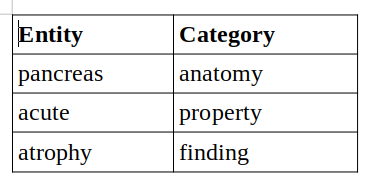


This function returns the longest substring in the list.

---


e.g. Input : ['left lobe', 'left', 'lobe'] 
    Output : 'left lobe'

Get relation between the entities in same noun chunk. 
e.g. *solid lesion* here *solid* and *lesion* are two different entities. And relation between them is *PropertyOf* (*solid, PropertyOf, lesion*)

Find entities in noun chunk. and find the relation between them.
e.g. *coarse echotexture* is noun chunk. In this module we are finding different entities like *coarse* and *echotexture*

In [ ]:
#--------------------------------demo
def remove_measurement(lines):
  ###print(lines)
  measure_unit = re.compile(r'(\d+ x \d+ x \d+ (mm|cm|cc))|(\d+.\d+ x \d+.\d+ x \d+.\d+ (mm|cm|cc))|(\d+ x \d+.\d+ x \d+.\d+ (mm|cm|cc))|(\d+ x \d+.\d+ x \d+ (mm|cm|cc))|(\d+ x \d+.\d+ (mm|cm|cc))|(\d+.\d+ x \d+ (mm|cm|cc))|(\d+.\d+ x \d+.\d+ (mm|cm|cc))|(\d+ x \d+ (mm|cm|cc))|(\d+ (cm|mm|cc))|(\d+.\d+ (cm|mm|cc))')
  newlines = []
  for line in lines:
    temp = re.sub(' measuring | measures | measure | vol | volume ', ' ', line)
    temp = re.sub(measure_unit, '', temp)
    temp = re.sub('\s+',' ', temp)
    newlines.append(temp)

  return newlines
    

def get_path_desc(lines):
  #-------------------remove all created files
  !rm FindingTriplets.csv
  !rm SuggestiveTriplets.csv
  !rm Triplets.csv
  !rm TripletsKG.csv
  !rm edges.txt
  organ = 'kidney'


  #-------------------Information Extraction

  lines_without_measure = remove_measurement(lines)
  #data_fl = open('Data_without_measure.txt','a')
  #data_fl.write(lines_without_measure[0] +'\n')
  #return
  print('size remove', lines_without_measure)
  #lines_without_measure = lines

  ie = IE(lines_without_measure)
  is_suggestive = ie.extract_information(lines_without_measure, lines)

  
  size_list = ie.extract_measurement(lines[0])

  df = pd.read_csv('TripletsKG.csv', delimiter=',')
  str_final = ''
  for index, row in df.iterrows():
    str_final = str_final + ", (" + row["ent1"] +','+ row["rel"] + ',' + row["ent2"] + ')'

  
  #--------------------------find missing entities from static KG and dynamic KG
  return str_final

#out = get_path_desc(['uterus is anteverted and normal in size shape contour with uniform echotexture'])
#print(path_desc)


lines = pd.read_csv('IE_input.csv', delimiter = '\t')
fl = open('IE.txt','w')

for index, row in lines.iterrows():
  line = row['path_desc']
  input = row['Input']
  #target = row['target1']
  print(line)
  ie = get_path_desc([line])
  try:
    fl.write(input + '\t' + line + '\t' + ie + '\n')
  except TypeError:
    continue


Streaming output truncated to the last 5000 lines.
increased ['increased', 'reflectivity'] ['VERB', 'NOUN']
obj increased reflectivity
token with
adp with
token reduced reflectivity
reduced ['reduced', 'reflectivity'] ['VERB', 'NOUN']
the ['the', 'body'] ['DET', 'NOUN']
reduced ['reduced', 'reflectivity'] ['VERB', 'NOUN']
token bulky reveals
bulky ['bulky', 'reveals'] ['ADJ', 'NOUN']
reveals ['bulky', 'reveals'] ['ADJ', 'NOUN']
token is
is ['is'] ['VERB']
verb sub [pancreas] is
bulky ['bulky', 'reveals'] ['ADJ', 'NOUN']
reveals ['bulky', 'reveals'] ['ADJ', 'NOUN']
bulky ['bulky', 'reveals'] ['ADJ', 'NOUN']
reveals ['bulky', 'reveals'] ['ADJ', 'NOUN']
leaf .
token .
. ['.'] ['PUNCT']
token is
is ['is'] ['VERB']
verb sub [pancreas] is
pancreas is slightly small reveals thin inhomogenous paranchyma. the pancreatic duct is dilated . multiple intraductal calculi seen. a thin walled cyst in the postero inferior to body and tail.
rm: cannot remove 'SuggestiveTriplets.csv': No such file or dir

In [ ]:
'''import anvil.server
anvil.server.connect("RK5TUDMODJRHSDS2ZP4NPC6M-UQ3YSW7JTGUZRBYJ")
@anvil.server.callable
def get_pathological_description(line):
  ##print(line)
  lines = []
  lines.append(line)
  #lines = ['Notable feature is that a thick walled sharply marginated hypoechoic area 11.3 x 7.2cm is noted posteriorly within right lobe (segments VII and segment VIII) with low level internal echoes seen within.']
  path_desc, image, doc_obj = get_path_desc(lines)
  return path_desc, image, doc_obj
anvil.server.wait_forever()'''

'import anvil.server\nanvil.server.connect("RK5TUDMODJRHSDS2ZP4NPC6M-UQ3YSW7JTGUZRBYJ")\n@anvil.server.callable\ndef get_pathological_description(line):\n  ##print(line)\n  lines = []\n  lines.append(line)\n  #lines = [\'Notable feature is that a thick walled sharply marginated hypoechoic area 11.3 x 7.2cm is noted posteriorly within right lobe (segments VII and segment VIII) with low level internal echoes seen within.\']\n  path_desc, image, doc_obj = get_path_desc(lines)\n  return path_desc, image, doc_obj\nanvil.server.wait_forever()'

In [ ]:
import spacy
import en_core_web_md
loadedmd = en_core_web_md.load()
nlp = loadedmd

nlp.add_pipe(nlp.create_pipe('merge_noun_chunks'))
doc = nlp(u"uterus is anteverted and normal in size shape contour with uniform echotexture")

spacy.displacy.render(doc, style='dep', jupyter=True, options={'distance': 150, 'offset_x':150, 'arrow_width':7,  'arrow_stroke':1})